# TS Analysis Final Project

In [ ]:
# univariate SARIMA
# univariate ETS 
# multivariate SARIMAX
# VAR if time allows
# use RMSE and 80% cross validation split

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import sklearn.metrics as skmetrics #For evaluation metrics
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import arma_order_select_ic
# getting weird errors for pmdarima - uncomment line below if needed
# ! pip install pmdarima
import pmdarima as pm
import warnings                    
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import holidays
warnings.filterwarnings('ignore')
import logging
from tqdm import tqdm 
from statsmodels.tsa.api import VAR
logging.getLogger('fbprophet').setLevel(logging.WARNING) 
%config InlineBackend.figure_format = 'retina'
import math

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ModuleNotFoundError: ignored

## Function Definitions

In [ ]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff
def rmse_sarima(data, p_values,d_values,q_values,P_values,Q_values, m, D=1,):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                    mse=res.mse
                                    rmse = math.sqrt(mse)
                                    if rmse < best_score:
                                        best_score, best_order, best_seasonal_order=rmse, order,seasonal_order
                                except:
                                    continue
    print((best_score, best_order, best_seasonal_order))
  
def evaluate_sarima_model(X, trend_order, seasonal_order,split=0.8):
    train_size = int(len(X) * split)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return rmse, mae, mape

def evaluate_ETS_model(X, trend_order, seasonal_order, split, m, damped_trend):
    train_size = int(len(X) * split)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(X[:train_size+t], trend=trend_order, seasonal=seasonal_order, 
                                     seasonal_periods=m, damped=damped_trend) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = model_fit.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
    mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = np.mean(np.abs(test-predictions)/test)
    return mae, rmse, mape

def invert_transformation(dt_train, dt_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    dt_fc = dt_forecast.copy()
    columns = train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            dt_fc[str(col)+'_1d'] = (train[col].iloc[-1]-train[col].iloc[-2]) + dt_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        dt_fc[str(col)+'_forecast'] = train[col].iloc[-1] + dt_fc[str(col)+'_1d'].cumsum()
    return dt_fc

def evaluate_SARIMAX_model(X, trend_order, seasonal_order,split=0.8):
    train_size = int(len(X) * split)
    og_train, og_test = X[0:train_size], X[train_size:]['MedianSoldPrice_AllHomes.California']
    predictions = list()
    for t in tqdm(range(len(og_test))):
        train, test = X[0:train_size+t], X[train_size+t:]
        sc = MinMaxScaler(feature_range=(0, 1))
        train_sc = sc.fit_transform(train)
        test_sc = sc.transform(test)
        model = sm.tsa.statespace.SARIMAX(train_sc[:,0], train_sc[:,1:],
                                          order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        y_pred = model_fit.predict(n_periods=len(test_sc), X = test_sc[:,1:]).reshape(-1,1)
        y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
        y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column
        predictions.append(y_pred_inv[0]) #store first prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(og_test).reshape(-1,)
    mae = skmetrics.mean_absolute_error(og_test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(og_test, predictions))
    mape = np.mean(np.abs(og_test-predictions)/og_test)
    return rmse, mae, mape
def evaluate_VAR_model(X, y, lag_order, split):
  train_size = int(len(X) * split)
  train, test = X[0:train_size], X[train_size:]
  predictions = list()
  for t in range(len(test)):
    x_train = X[:train_size+t]
    model = VAR(x_train)
    results = model.fit(lag_order)
    lagged_values = x_train.values[-lag_order:]
    yhat = results.forecast(lagged_values, 1) #predict one step 
    preds_df = pd.DataFrame(yhat, columns=train.columns + '_1d')
    #  #store prediction
    y_pred = invert_transformation(train, preds_df, second_diff=True)[y + '_1d'][0]
    predictions.append(y_pred)
  mae = skmetrics.mean_absolute_error(test[y], predictions)
  rmse = np.sqrt(skmetrics.mean_squared_error(test[y], predictions))
  mape = np.mean(np.abs(test[y]-predictions)/test[y])
  return mae, rmse, mape

In [ ]:
data = pd.read_csv('zillow-carlifornia.csv', index_col=0, parse_dates=True, squeeze=True)
train, valid = data[data.index <= '2014-12-31'], data[data.index > '2014-12-31'].dropna()

## Univariate (S)ARIMA Approach

In [ ]:
# univariate (S)ARIMA
uni_data = pd.read_csv('zillow-carlifornia.csv', index_col=0, parse_dates=True, squeeze=True).dropna()
uni_data = uni_data['MedianSoldPrice_AllHomes.California']
train = train['MedianSoldPrice_AllHomes.California']
valid = valid['MedianSoldPrice_AllHomes.California']

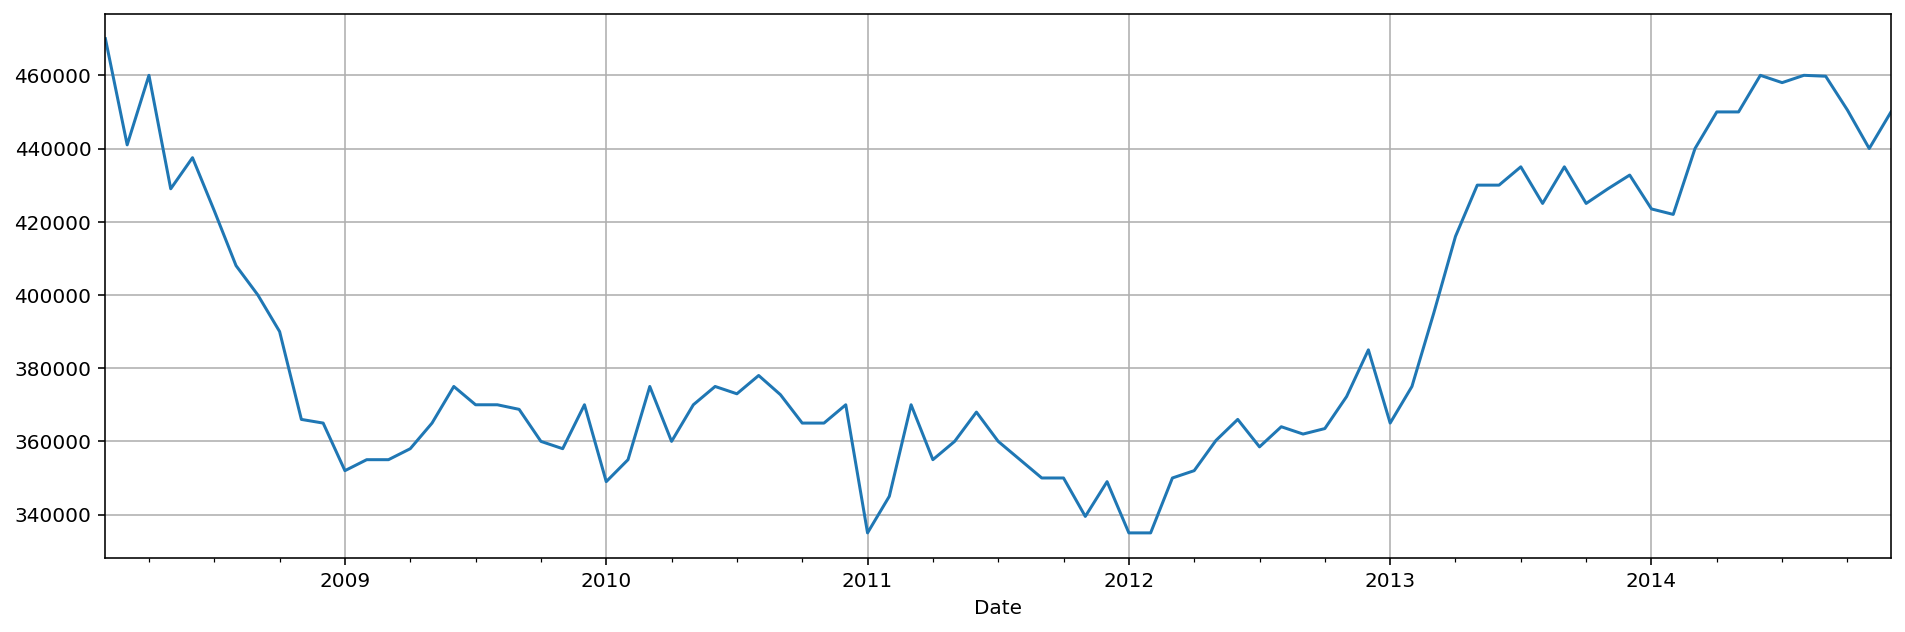

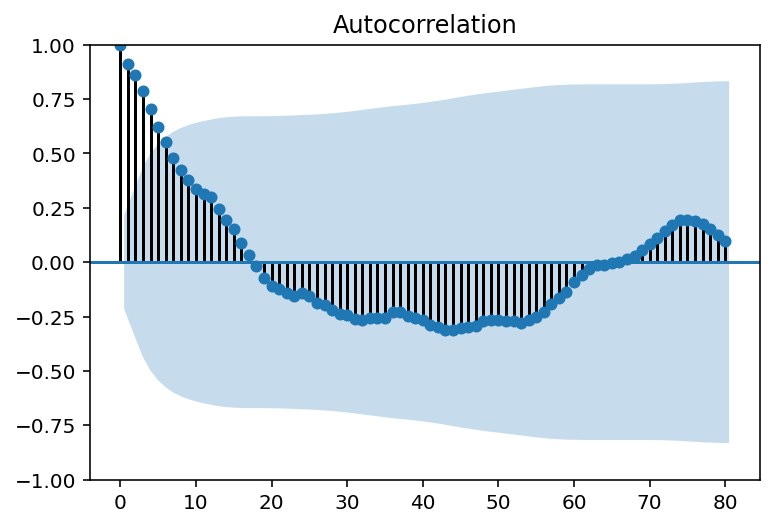

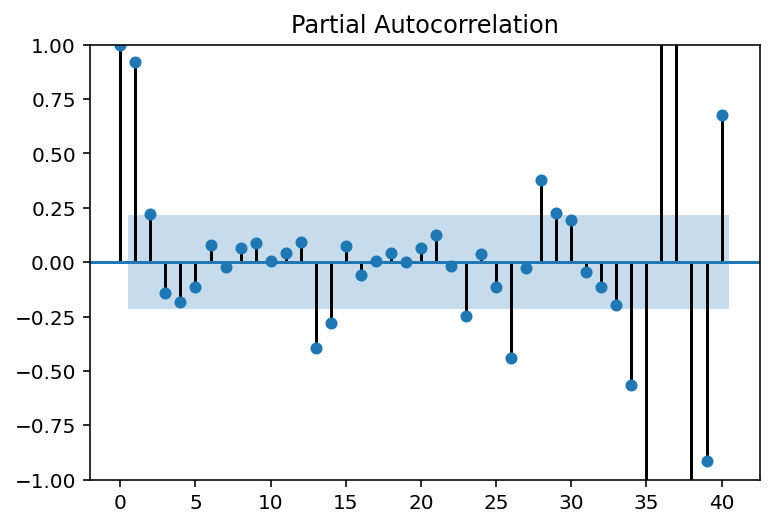

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -0.622849
p-value                         0.865735
#Lags Used                     12.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [ ]:
fig = plt.figure(figsize=(16,5))
train.plot()
plt.grid()

plt.show()
# ACF
plot_acf(train, lags=80)
plt.show()
# PACF
plot_pacf(train, lags=40)
plt.show()
# ADF 
    
adf_test(train)

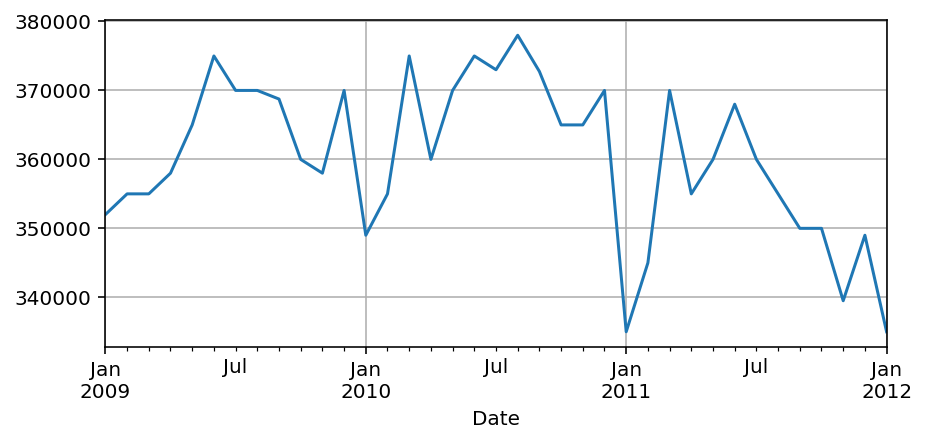

In [ ]:
fig = plt.figure(figsize=(7,3))
train[11:48].plot()
plt.grid()
# seasonal = 12

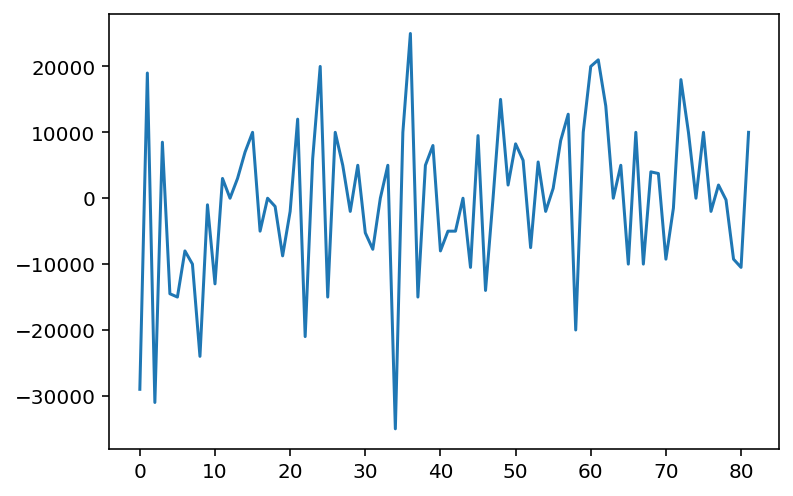

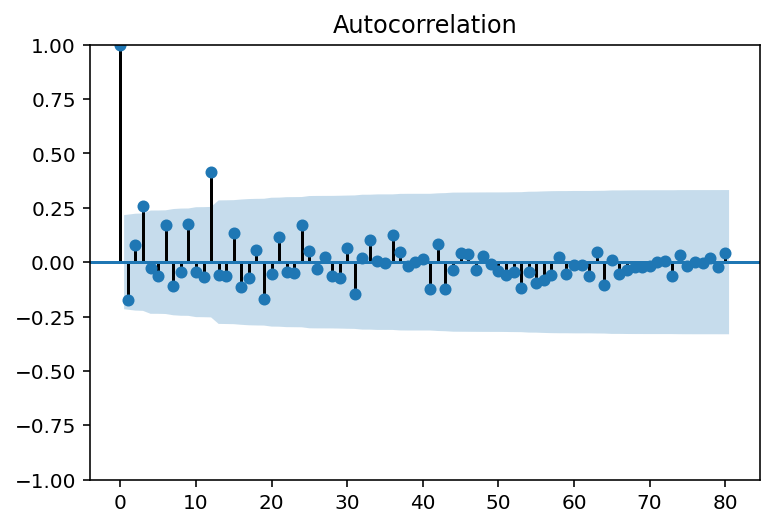

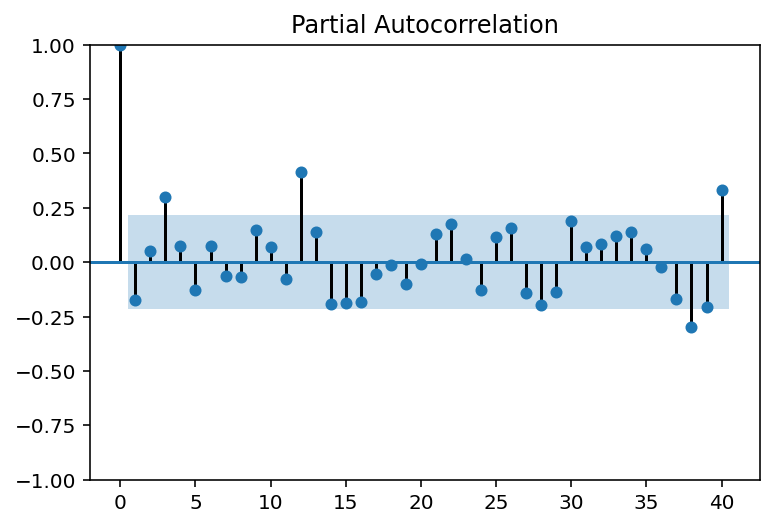

Test Statistic   -2.832949
p-value           0.053719
dtype: float64


In [ ]:
# difference once 
d1 = diff(train,interval=1)
plt.plot(d1)
plot_acf(d1,lags=80) 
plt.show()
plot_pacf(d1,lags=40) 
plt.show()

dftest = adfuller(d1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)
# d1 close to stationary, not that bad

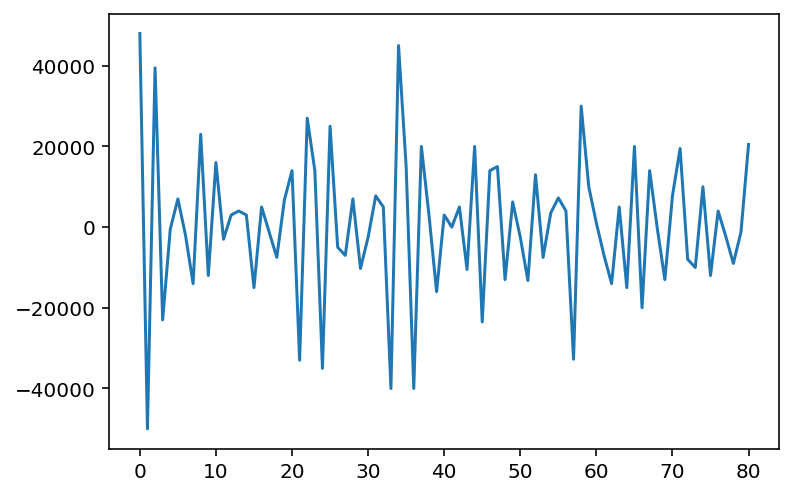

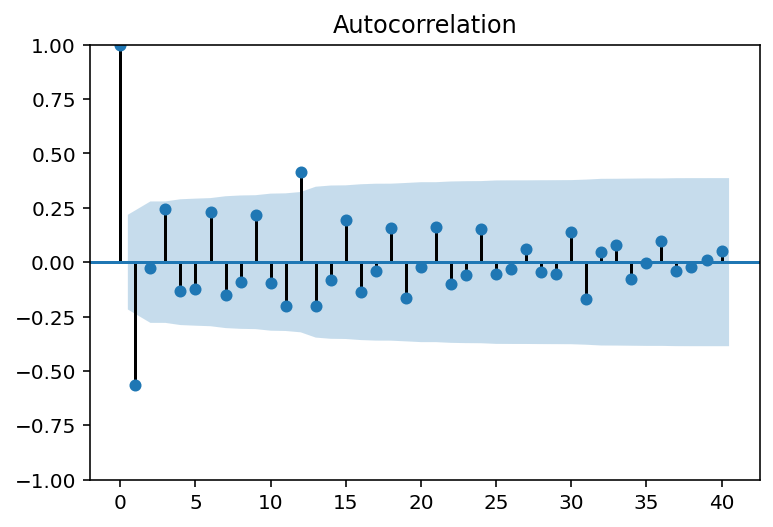

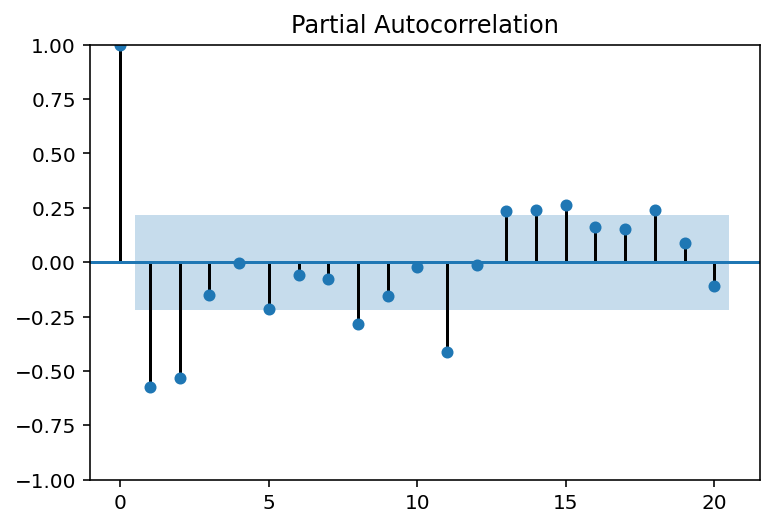

Test Statistic   -6.558448e+00
p-value           8.499491e-09
dtype: float64


In [ ]:
d2 = diff(d1, 1)
plt.plot(d2)
plot_acf(d2,lags=40) 
plt.show()
plot_pacf(d2,lags=20) 
plt.show()
dftest = adfuller(d2)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)
# d=2 stationary

In [ ]:
arma_order_select_ic(d2,max_ar=4, max_ma=4, ic='aic')

{'aic':              0            1            2            3            4
 0  1821.222386  1755.961364  1753.835754  1753.873025  1753.088864
 1  1787.721625  1753.426677  1758.360090  1757.836054  1754.738755
 2  1761.487538  1755.376350  1756.563298  1750.063726  1751.375011
 3  1760.514724  1762.146243  1754.448661          NaN          NaN
 4  1762.474825  1754.447095  1754.435985  1751.494889  1753.006471,
 'aic_min_order': (2, 3)}

In [ ]:
# candidate model 1: ARIMA(2,2,3)

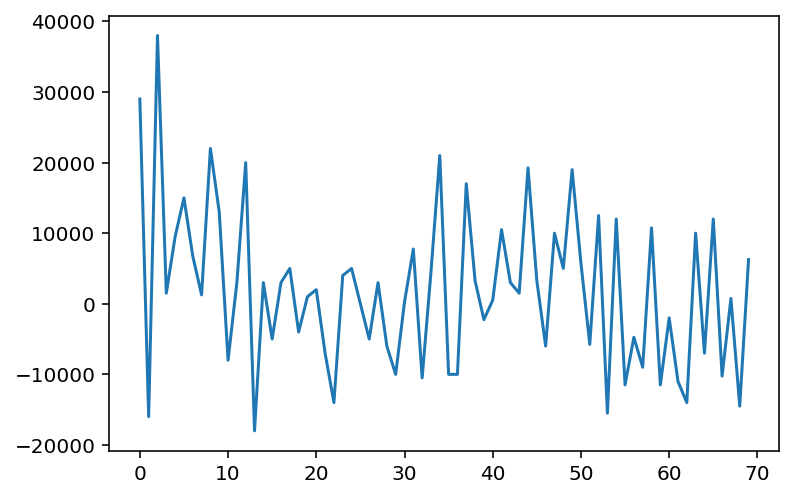

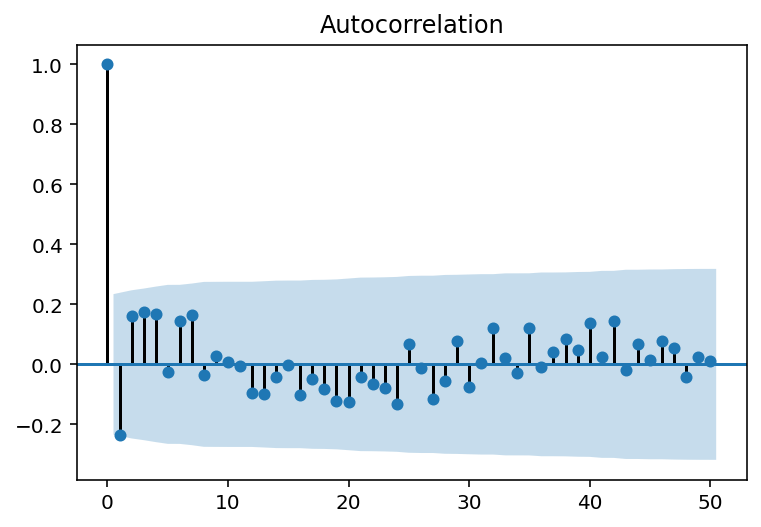

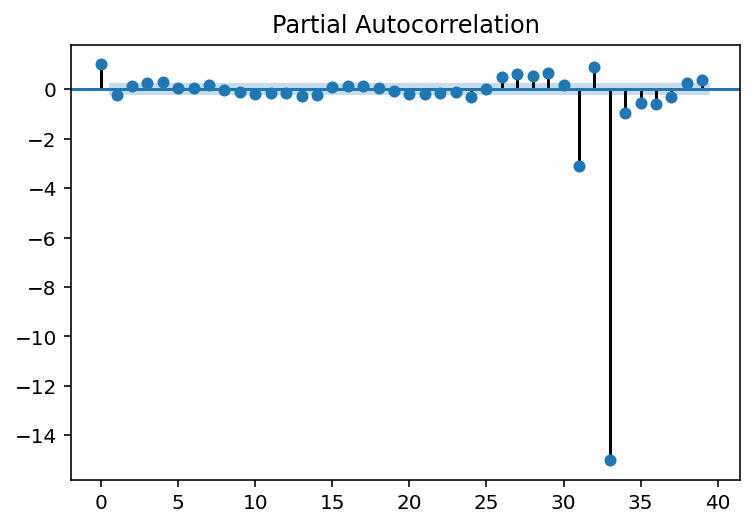

In [ ]:
#seasonal differencing
# d = diff(d1, 12) # m=12 seasonal differencing
# plt.plot(d)
# plot_acf(d,lags=50) 
# plt.show()
# plot_pacf(d,lags=39) 
# plt.show()

# PACF hard to decided q, abandon

In [ ]:
rmse_sarima(train,range(0,5),range(0,3),range(0,5),range(0,3),range(0,3),m=12)

(58525.40713273859, (1, 1, 0), (2, 1, 1, 12))


In [ ]:
# candidate mdoel 2: SARIMA(1,1,0), (2,1,1,12)

In [ ]:
model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # seasonal lag
                      d=1,           
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1508.652, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1503.116, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1504.660, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1502.028, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1503.064, Time=0.26 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1501.441, Time=0.07 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1502.618, Time=0.15 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=1502.574, Time=0.14 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=1494.363, Time=0.07 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1495.433, Time=0.17 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=1495.386, Time=0.19 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=1498.363, Time=0.25 sec
 ARIMA(4,1,0)(0,1,0)[12]     

In [ ]:
# candidate model 3: SARIMA(3,1,5)(0,1,0)[12]    

In [ ]:
rmse1, mae1, mape1 = evaluate_sarima_model(uni_data,(0,2,1), (0,0,0,0))
rmse2, mae2, mape2 = evaluate_sarima_model(uni_data,(1,1,0), (2,1,1,12))
rmse3, mae3, mape3 = evaluate_sarima_model(uni_data,(3,1,5), (0,1,0,12))

100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


In [ ]:
pd.DataFrame([(rmse1, mae1, mape1),(rmse2, mae2, mape2),(rmse3, mae3, mape3)], columns=['rmse', 'mae', 'mape'],index=['cand1','cand2','cand3'])

,rmse,mae,mape
cand1,10323.724271,8492.499691,0.018157
cand2,9876.756194,8348.990324,0.017904
cand3,9541.306637,7868.256706,0.016845


### Predict on validation

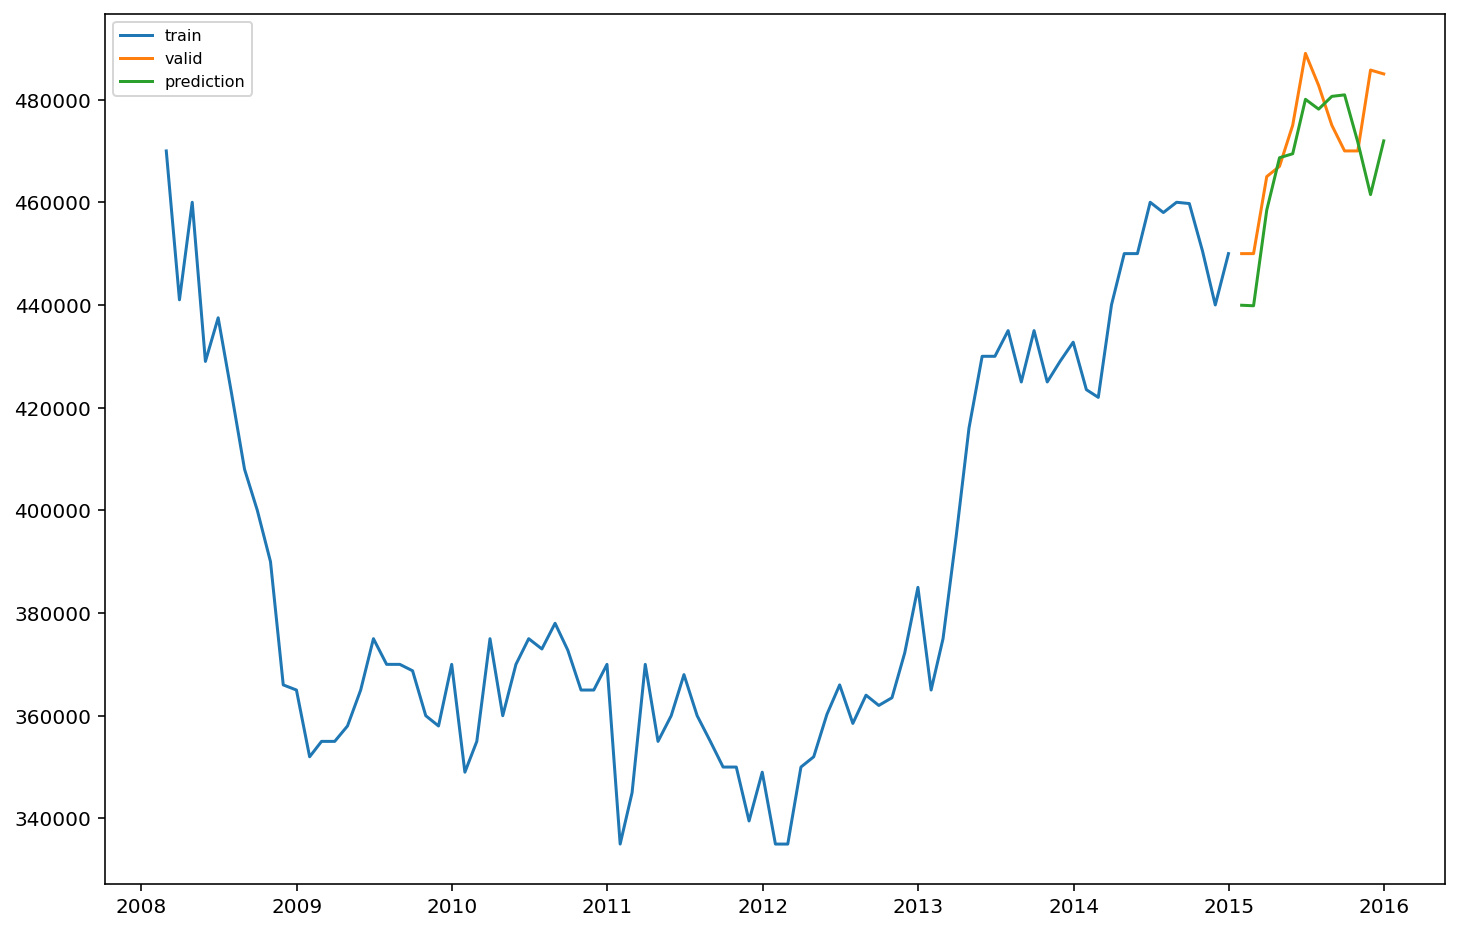

In [ ]:
mod1 = sm.tsa.statespace.SARIMAX(train,order=(3,1,5),seasonal_order=((0,1,0,12)))
res1 = mod1.fit()
plt.figure(figsize=(12, 8))
pred1=res1.predict(start=len(train), end=len(train)+11)
plt.plot(train, label= 'train')
plt.plot(valid, label= 'valid')
plt.plot(pred1, label='prediction')
plt.legend(loc='upperleft', fontsize=8)
plt.show()

In [ ]:
rmse = np.sqrt(skmetrics.mean_squared_error(valid, pred1))
print(f"RMSE: {rmse:6f}")

RMSE: 10384.301984


## Multivariate VAR 

In [ ]:
data = pd.read_csv('zillow-carlifornia.csv', index_col=0, parse_dates=True, squeeze=True)
train, valid = data[data.index <= '2014-12-31'], data[data.index > '2014-12-31'].dropna()

In [ ]:
train.columns

Index(['MedianSoldPrice_AllHomes.California', 'MedianMortageRate',
       'UnemploymentRate'],
      dtype='object')

### Check for stationarity

MedianSoldPrice_AllHomes.California
Results of Augmented Dickey-Fuller Test:
Test Statistic                 -0.622849
p-value                         0.865735
#Lags Used                     12.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64
MedianMortageRate
Results of Augmented Dickey-Fuller Test:
Test Statistic                 -1.669975
p-value                         0.446645
#Lags Used                      0.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64
UnemploymentRate
Results of Augmented Dickey-Fuller Test:
Test Statistic                 -3.170082
p-value                         0.021783
#Lags Used                     12.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.5274

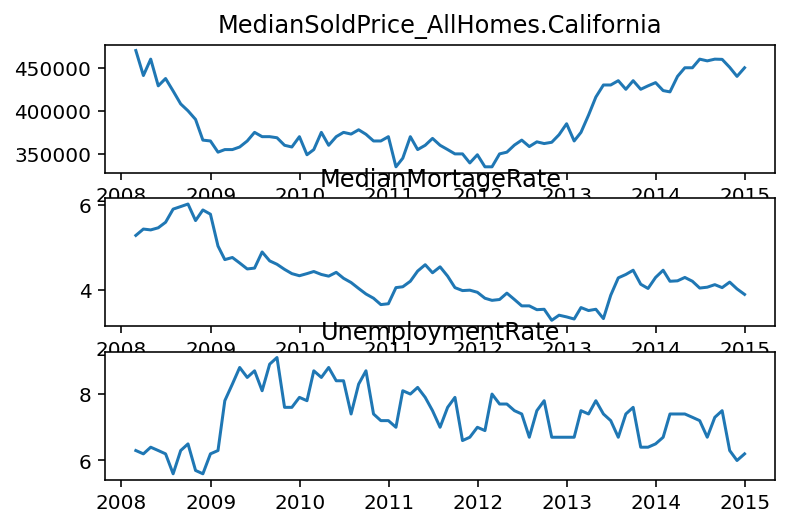

In [ ]:
fig, axes = plt.subplots(train.shape[1], 1)
for i, col in enumerate(train.columns):
  axes[i].plot(train[col])
  axes[i].set_title(col)
  print(col)
  adf_test(train[col])
plt.show()

MedianSoldPrice_AllHomes.California
Results of Augmented Dickey-Fuller Test:
Test Statistic                 -2.832949
p-value                         0.053719
#Lags Used                     11.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64
MedianMortageRate
Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.919918e+00
p-value                        3.748176e-12
#Lags Used                     0.000000e+00
Number of Observations Used    8.100000e+01
Critical Value (1%)           -3.513790e+00
Critical Value (5%)           -2.897943e+00
Critical Value (10%)          -2.586191e+00
dtype: float64
UnemploymentRate
Results of Augmented Dickey-Fuller Test:
Test Statistic                 -1.626914
p-value                         0.469106
#Lags Used                     11.000000
Number of Observations Used    70.000000
Critical Value (1

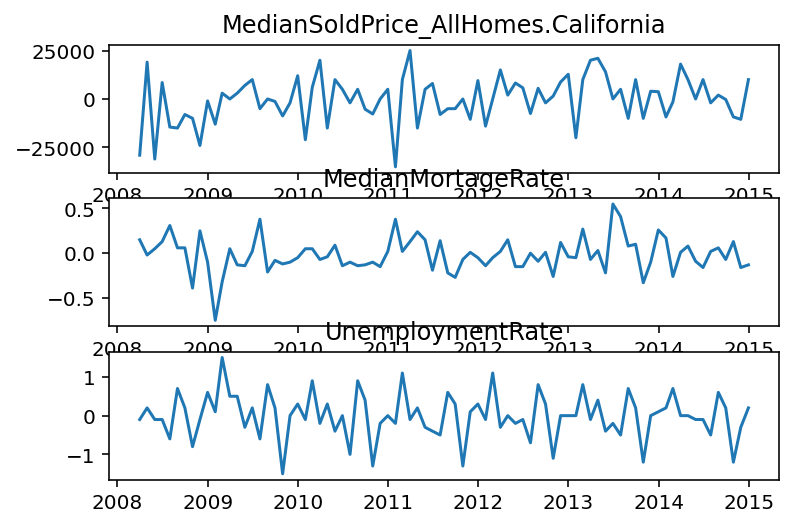

In [ ]:
# difference once
train_diff = train.diff().dropna()
# recheck 
fig, axes = plt.subplots(train_diff.shape[1], 1)
for i, col in enumerate(train_diff.columns):
  axes[i].plot(train_diff[col])
  axes[i].set_title(col)
  print(col)
  adf_test(train_diff[col])
plt.show()

MedianSoldPrice_AllHomes.California
Results of Augmented Dickey-Fuller Test:
Test Statistic                -6.558448e+00
p-value                        8.499491e-09
#Lags Used                     1.000000e+01
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64
MedianMortageRate
Results of Augmented Dickey-Fuller Test:
Test Statistic                 -4.915903
p-value                         0.000032
#Lags Used                      8.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64
UnemploymentRate
Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.482592e+01
p-value                        1.931790e-27
#Lags Used                     1.000000e+01
Number of Observations Used    7.000000e+01
Criti

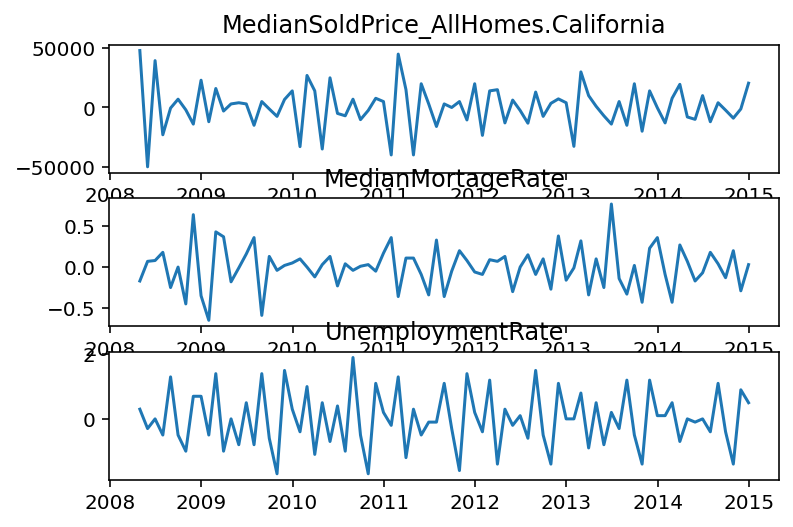

In [ ]:
# now failing ADF tests for unemployment and house price 
train_diff2 = train_diff.diff().dropna()
fig, axes = plt.subplots(train_diff2.shape[1], 1)
for i, col in enumerate(train_diff2.columns):
  axes[i].plot(train_diff2[col])
  axes[i].set_title(col)
  print(col)
  adf_test(train_diff2[col])
plt.show()

### Predict on validaton

In [ ]:
var_model = VAR(train_diff2)
results = var_model.fit(maxlags=15, ic='aic')

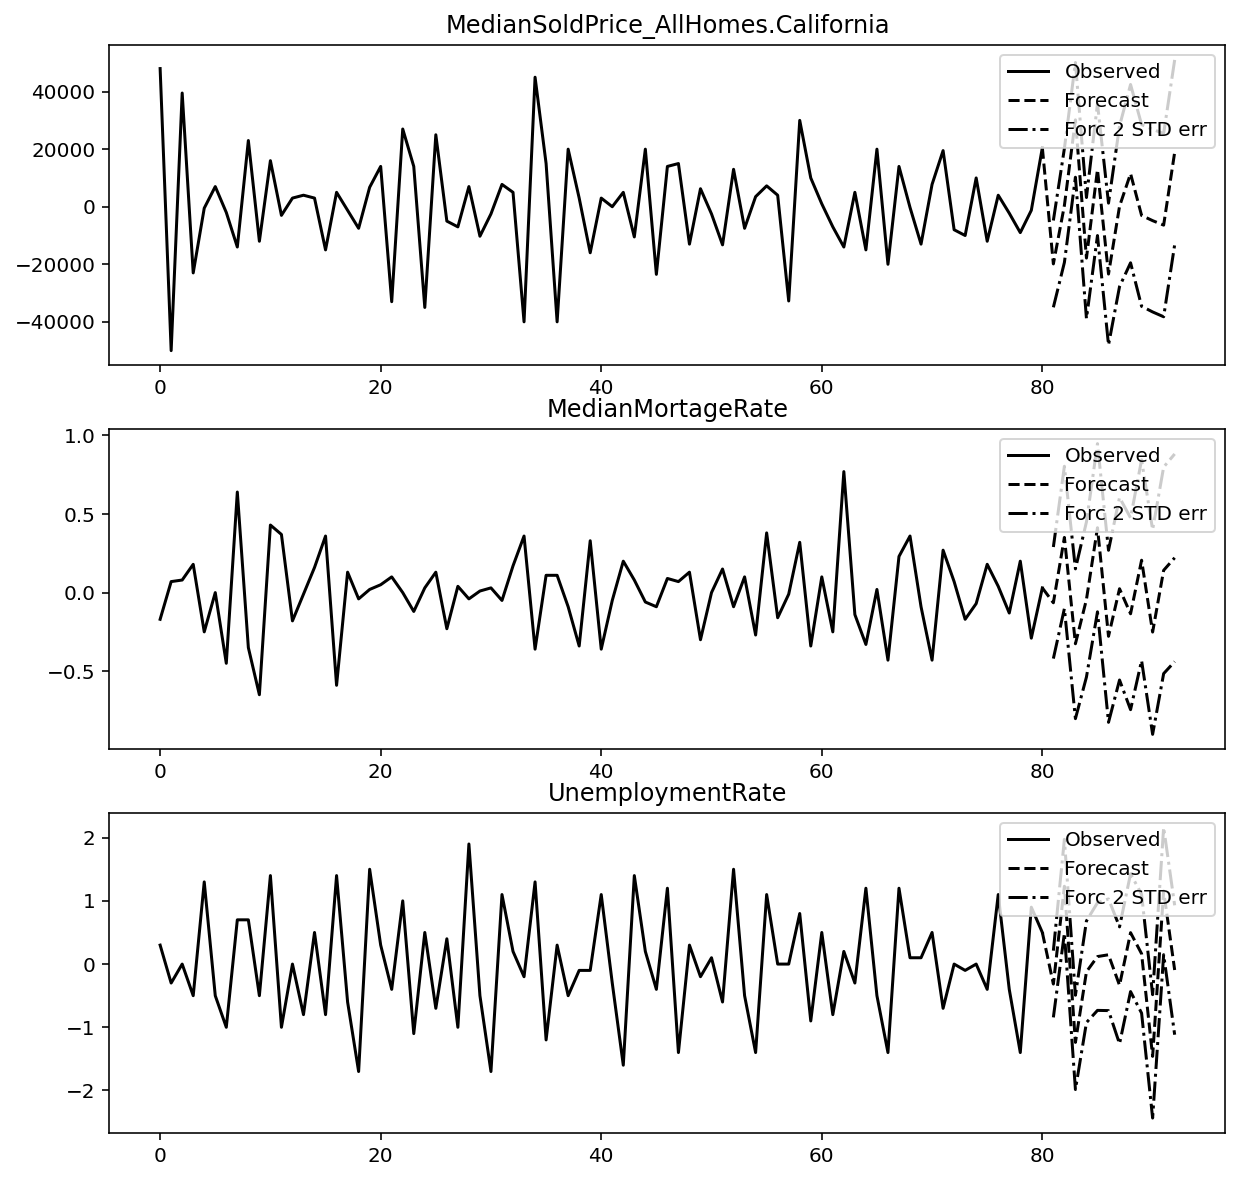

In [ ]:
results.plot_forecast(len(valid));

In [ ]:
lags = results.k_ar
print(lags)
preds = results.forecast(train_diff2.values[-lags:], len(valid['MedianSoldPrice_AllHomes.California']))
preds_df = pd.DataFrame(preds, columns=train.columns + '_1d')

15


In [ ]:
house_preds = invert_transformation(train, preds_df, second_diff=True)['MedianSoldPrice_AllHomes.California_forecast'].tail(12)

In [ ]:
rmse = np.sqrt(skmetrics.mean_squared_error(valid['MedianSoldPrice_AllHomes.California'], house_preds))
print(f"RMSE: {rmse:6f}")

RMSE: 21019.663899


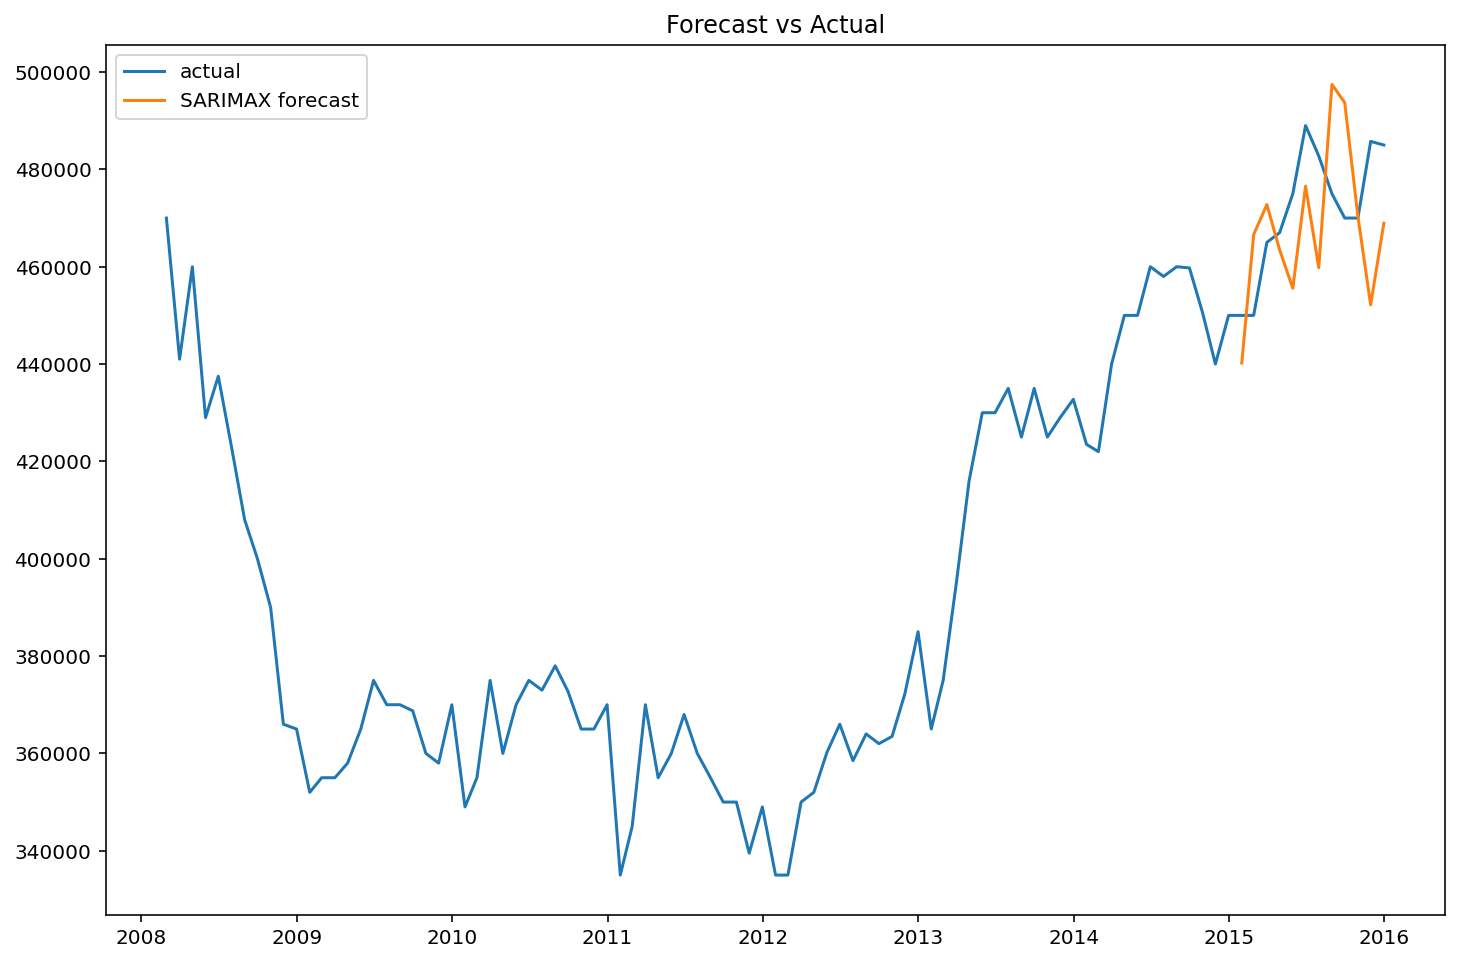

In [ ]:
y_pred_series = pd.Series(house_preds.values,index=valid.index)
plt.figure(figsize=(12, 8))

plt.plot(data['MedianSoldPrice_AllHomes.California'], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left')
plt.title('Forecast vs Actual')
plt.show()

## Multivariate SARIMAX

### Find parameters and fit model


In [ ]:
data = pd.read_csv('zillow-carlifornia.csv', index_col=0, parse_dates=True, squeeze=True)
train, valid = data[data.index <= '2014-12-31'], data[data.index > '2014-12-31'].dropna()

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
train_sc = sc.fit_transform(train)
valid_sc = sc.transform(valid)

In [ ]:
# using AIC to tune parameters
model = pm.auto_arima(train_sc[:,0].reshape(-1, 1), # median price as endogenous
                 exogenous=train_sc[:,1:], # mortgage and unemployment as exogenous
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=2, seasaonal=True,
                 m=12, # yearly seasonality
                 D=1, max_P=5, max_Q=5,
                 trace=True,
                 error_action='ignore', 
                 suppress_warnings=True,
                 information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-140.596, Time=0.71 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-144.310, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-146.007, Time=0.55 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-144.577, Time=0.61 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-146.026, Time=0.09 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-146.906, Time=0.35 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-145.565, Time=0.88 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-145.589, Time=0.79 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-143.608, Time=1.33 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-143.634, Time=0.42 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=-152.524, Time=0.83 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=-149.634, Time=0.24 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=-151.875, Time=1.25 sec
 ARIMA(2,1,0)(1,1,0)[12]

In [ ]:
rmses = []
for p in range(5):
  for q in range(5):
    for d in range(2):
      rmse = evaluate_SARIMAX_model(train, trend_order=(p,d,q), seasonal_order=(0,1,2,12))[1]
      rmses.append(rmse)
      print(f"trend_order = {p, d, q}, RMSE: {rmse:2f}")

100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


trend_order = (0, 0, 0), RMSE: 101858.995863


100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


trend_order = (0, 1, 0), RMSE: 127122.544678


100%|██████████| 17/17 [00:21<00:00,  1.29s/it]


trend_order = (0, 0, 1), RMSE: 102719.829338


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


trend_order = (0, 1, 1), RMSE: 126780.456599


100%|██████████| 17/17 [00:27<00:00,  1.60s/it]


trend_order = (0, 0, 2), RMSE: 110175.757055


100%|██████████| 17/17 [00:21<00:00,  1.27s/it]


trend_order = (0, 1, 2), RMSE: 139021.145336


100%|██████████| 17/17 [00:28<00:00,  1.70s/it]


trend_order = (0, 0, 3), RMSE: 142078.591814


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


trend_order = (0, 1, 3), RMSE: 133467.371498


100%|██████████| 17/17 [00:36<00:00,  2.15s/it]


trend_order = (0, 0, 4), RMSE: 120984.910883


100%|██████████| 17/17 [00:34<00:00,  2.01s/it]


trend_order = (0, 1, 4), RMSE: 132803.346265


100%|██████████| 17/17 [00:22<00:00,  1.32s/it]


trend_order = (1, 0, 0), RMSE: 125890.576589


100%|██████████| 17/17 [00:18<00:00,  1.11s/it]


trend_order = (1, 1, 0), RMSE: 128143.505987


100%|██████████| 17/17 [00:25<00:00,  1.51s/it]


trend_order = (1, 0, 1), RMSE: 124868.317565


100%|██████████| 17/17 [00:27<00:00,  1.62s/it]


trend_order = (1, 1, 1), RMSE: 127857.738713


100%|██████████| 17/17 [00:30<00:00,  1.82s/it]


trend_order = (1, 0, 2), RMSE: 139586.751067


100%|██████████| 17/17 [00:29<00:00,  1.76s/it]


trend_order = (1, 1, 2), RMSE: 120835.936468


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


trend_order = (1, 0, 3), RMSE: 133964.822944


100%|██████████| 17/17 [00:34<00:00,  2.03s/it]


trend_order = (1, 1, 3), RMSE: 127586.466904


100%|██████████| 17/17 [00:39<00:00,  2.33s/it]


trend_order = (1, 0, 4), RMSE: 132497.605158


100%|██████████| 17/17 [00:38<00:00,  2.29s/it]


trend_order = (1, 1, 4), RMSE: 132368.155015


100%|██████████| 17/17 [00:24<00:00,  1.45s/it]


trend_order = (2, 0, 0), RMSE: 126164.697337


100%|██████████| 17/17 [00:24<00:00,  1.41s/it]


trend_order = (2, 1, 0), RMSE: 139744.025539


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


trend_order = (2, 0, 1), RMSE: 129075.445813


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


trend_order = (2, 1, 1), RMSE: 130758.622966


100%|██████████| 17/17 [00:34<00:00,  2.04s/it]


trend_order = (2, 0, 2), RMSE: 129401.121976


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


trend_order = (2, 1, 2), RMSE: 125994.910189


100%|██████████| 17/17 [00:35<00:00,  2.06s/it]


trend_order = (2, 0, 3), RMSE: 133744.822393


100%|██████████| 17/17 [00:37<00:00,  2.20s/it]


trend_order = (2, 1, 3), RMSE: 125412.489762


100%|██████████| 17/17 [00:42<00:00,  2.48s/it]


trend_order = (2, 0, 4), RMSE: 133984.071587


100%|██████████| 17/17 [00:41<00:00,  2.46s/it]


trend_order = (2, 1, 4), RMSE: 129838.560172


100%|██████████| 17/17 [00:26<00:00,  1.56s/it]


trend_order = (3, 0, 0), RMSE: 140716.157290


100%|██████████| 17/17 [00:27<00:00,  1.62s/it]


trend_order = (3, 1, 0), RMSE: 136833.978048


100%|██████████| 17/17 [00:30<00:00,  1.79s/it]


trend_order = (3, 0, 1), RMSE: 137052.147028


100%|██████████| 17/17 [00:33<00:00,  1.99s/it]


trend_order = (3, 1, 1), RMSE: 125995.732626


100%|██████████| 17/17 [00:38<00:00,  2.24s/it]


trend_order = (3, 0, 2), RMSE: 131553.991165


100%|██████████| 17/17 [00:33<00:00,  1.98s/it]


trend_order = (3, 1, 2), RMSE: 124399.572171


100%|██████████| 17/17 [00:38<00:00,  2.24s/it]


trend_order = (3, 0, 3), RMSE: 133458.759354


100%|██████████| 17/17 [00:41<00:00,  2.44s/it]


trend_order = (3, 1, 3), RMSE: 125854.592814


100%|██████████| 17/17 [00:46<00:00,  2.72s/it]


trend_order = (3, 0, 4), RMSE: 133959.196725


100%|██████████| 17/17 [00:45<00:00,  2.66s/it]


trend_order = (3, 1, 4), RMSE: 122132.869262


100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


trend_order = (4, 0, 0), RMSE: 137992.131972


100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


trend_order = (4, 1, 0), RMSE: 122745.472321


100%|██████████| 17/17 [00:33<00:00,  1.96s/it]


trend_order = (4, 0, 1), RMSE: 140025.595676


100%|██████████| 17/17 [00:37<00:00,  2.23s/it]


trend_order = (4, 1, 1), RMSE: 120268.634817


100%|██████████| 17/17 [00:43<00:00,  2.55s/it]


trend_order = (4, 0, 2), RMSE: 127642.444755


100%|██████████| 17/17 [00:37<00:00,  2.21s/it]


trend_order = (4, 1, 2), RMSE: 121141.627060


100%|██████████| 17/17 [00:48<00:00,  2.87s/it]


trend_order = (4, 0, 3), RMSE: 134163.867722


100%|██████████| 17/17 [00:44<00:00,  2.64s/it]


trend_order = (4, 1, 3), RMSE: 124336.731522


100%|██████████| 17/17 [00:51<00:00,  3.02s/it]


trend_order = (4, 0, 4), RMSE: 124331.416404


100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

trend_order = (4, 1, 4), RMSE: 124615.211626


In [ ]:
print(min(rmses))

101858.99586260607


In [ ]:
evaluate_SARIMAX_model(train, trend_order=(0, 0, 0), seasonal_order=(0, 1, 2, 12))[1]

100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


101858.99586260607

### Predict on validation

In [ ]:
data = pd.read_csv('zillow-carlifornia.csv', index_col=0, parse_dates=True, squeeze=True)
train, valid = data[data.index <= '2014-12-31'], data[data.index > '2014-12-31'].dropna()

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
train_sc = sc.fit_transform(train)
valid_sc = sc.transform(valid)

In [ ]:
model = sm.tsa.statespace.SARIMAX(train_sc[:,0], exog=train_sc[:,1:],
                                          order=(0, 0, 0),seasonal_order=(0, 1, 2, 12))

In [ ]:
# len(valid_sc)
model_fit = model.fit()
y_pred = model_fit.forecast(steps=len(valid), exog = valid_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0] # inverset the pred and take the first column (gdp)

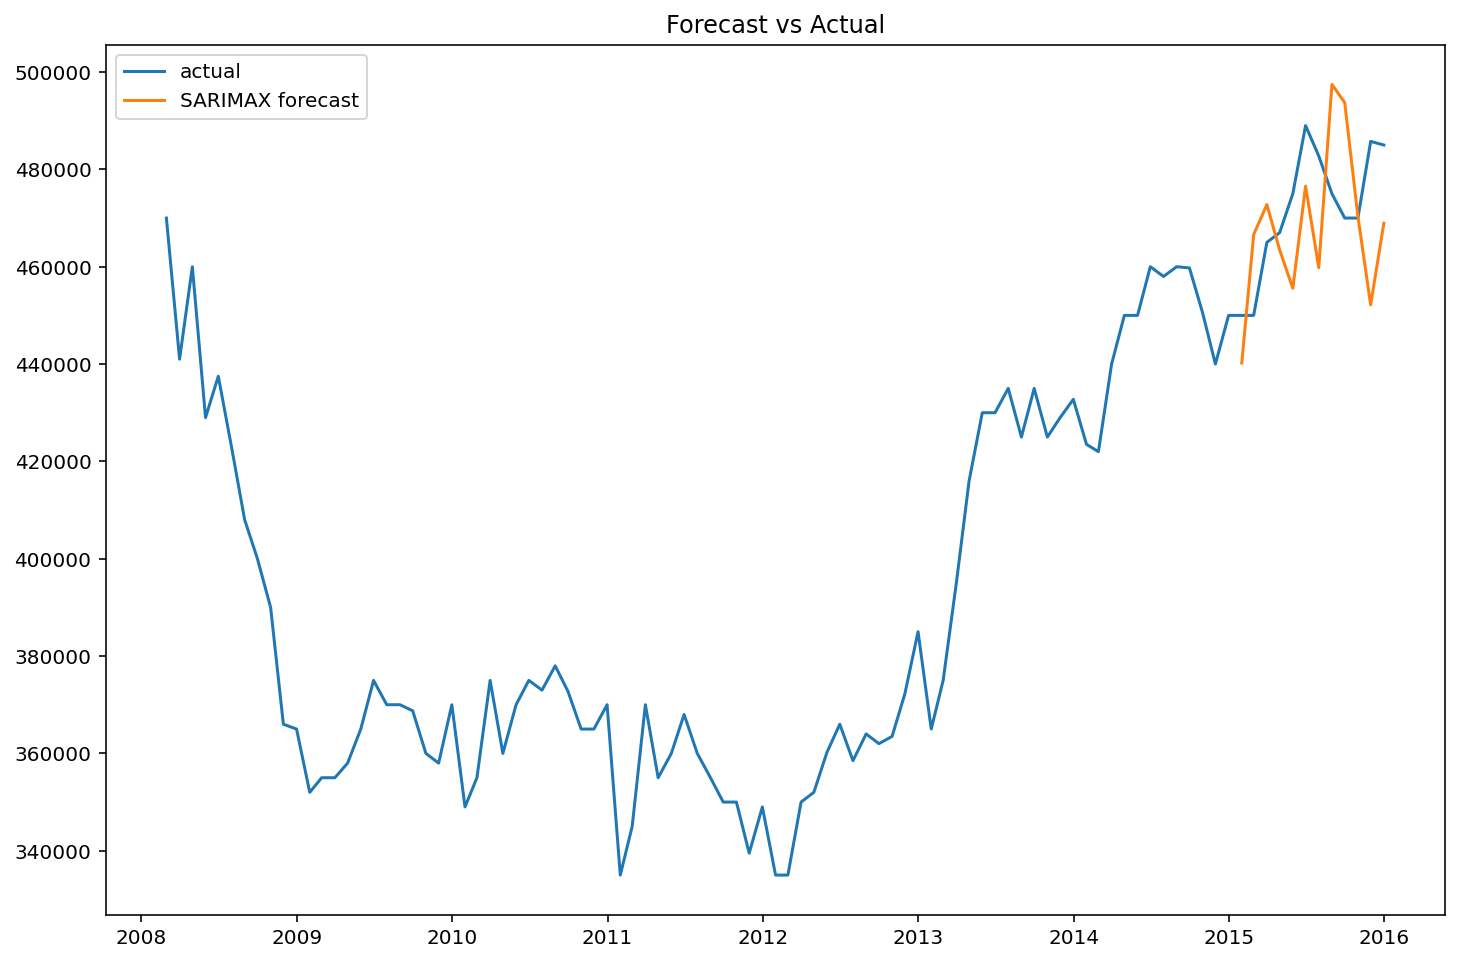

In [ ]:
y_pred_series = pd.Series(y_pred_inv,index=valid.index)
plt.figure(figsize=(12, 8))

plt.plot(data['MedianSoldPrice_AllHomes.California'], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left')
plt.title('Forecast vs Actual')
plt.show()

In [ ]:
rmse = np.sqrt(skmetrics.mean_squared_error(valid['MedianSoldPrice_AllHomes.California'], y_pred_inv))
print(f"RMSE: {rmse:6f}")

RMSE: 18159.420741


## Univariate ETS

### Find Parameters and fit model

In [ ]:
# reset data 

ets_s = pd.read_csv('zillow-carlifornia.csv',header=0, parse_dates=True, squeeze=True)
ets_s['Date']= pd.to_datetime(ets_s['Date'])
ets_train = ets_s[ets_s['Date'] <= '2014-12-31']
ets_train = ets_train.set_index('Date')
ets_val = ets_s[ets_s['Date'] > '2014-12-31']
ets_val = ets_val[ets_val['Date'] < '2016-01-31']
ets_val = ets_val.set_index('Date')
ets_x_val = np.array(ets_val['MedianSoldPrice_AllHomes.California'])
ets_x_train = np.array(ets_train['MedianSoldPrice_AllHomes.California'])

In [ ]:
trend = ['add', 'mul', None]
seasonality = ['add', 'mul']
best_score, best_trend, best_seasonal = float('inf'), None, None 
for t in trend:
    for s in seasonality:
        damped_trend = True
        if t is None:
            damped_trend = False
        mae, rmse, mape = evaluate_ETS_model(ets_x_train, t, s, 0.8, 12, damped_trend)
        if rmse < best_score:
            best_score = rmse
            best_trend = t
            best_seasonal = s
print('RMSE: ' + str(best_score))
print('trend order: ' + str(best_trend))
print('seasonality order: ' + str(best_seasonal))

RMSE: 6615.77446075924
trend order: None
seasonality order: add


### Predict on validation

In [ ]:
modh = ExponentialSmoothing(ets_x_train, trend=None, seasonal='add', seasonal_periods=12,damped=False)
resh = modh.fit()
predh=resh.predict(start=len(ets_x_train)-1, end=len(ets_x_train)+10)
predh_df = pd.DataFrame(predh)
predh_df.index += len(ets_x_train) - 1

pred_df = pd.DataFrame(ets_x_val)
pred_df.index += len(ets_x_train) - 1

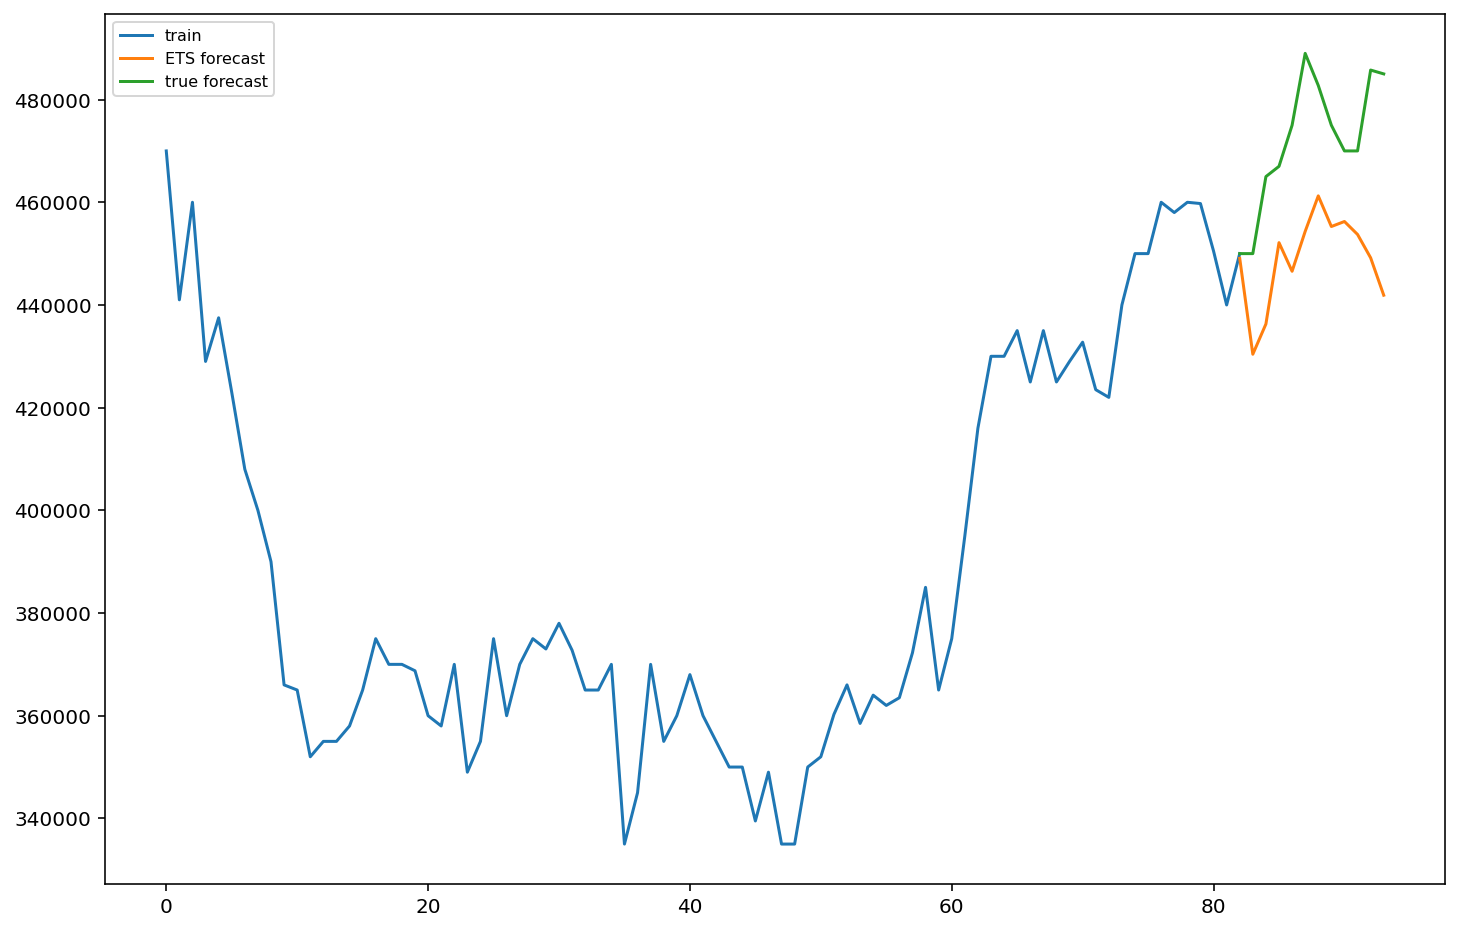

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(ets_x_train, label='train')
plt.plot(predh_df, label='ETS forecast')
plt.plot(pred_df, label='true forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
ets_rmse = np.sqrt(skmetrics.mean_squared_error(ets_x_val, predh))
print(f"RMSE: {ets_rmse:6f}")

RMSE: 25724.052056


# Final Model

SARIMA (3, 1, 5) (0, 1, 0, 12)


In [ ]:
final_train = pd.read_csv('zillow-carlifornia.csv',header=0, parse_dates=True, squeeze=True)
final_train['Date']= pd.to_datetime(final_train['Date'])
final_train = final_train[final_train['Date'] < '2016-01-31']
final_train = final_train.set_index('Date')
final_train = np.array(final_train['MedianSoldPrice_AllHomes.California'])
test = pd.read_csv('test.csv',header=0, parse_dates=True, squeeze=True)
test['Month']= pd.to_datetime(test['Month'])
test = test.set_index('Month')
test = np.array(test['Median House Price'])
mod1 = sm.tsa.statespace.SARIMAX(final_train,order=(3,1,5),seasonal_order=((0,1,0,12)))
res1 = mod1.fit()
pred1=res1.predict(start=len(final_train), end=len(final_train)+11)
np.sqrt(skmetrics.mean_squared_error(test, pred1))

14322.898137539669

In [ ]:
points = pd.read_csv('zillow-carlifornia.csv',header=0, parse_dates=True, squeeze=True).index
dates = pd.read_csv('zillow-carlifornia.csv',header=0, parse_dates=True, squeeze=True)['Date']
dates = [d.split('-')[0] for d in dates]
dates = np.unique(dates)

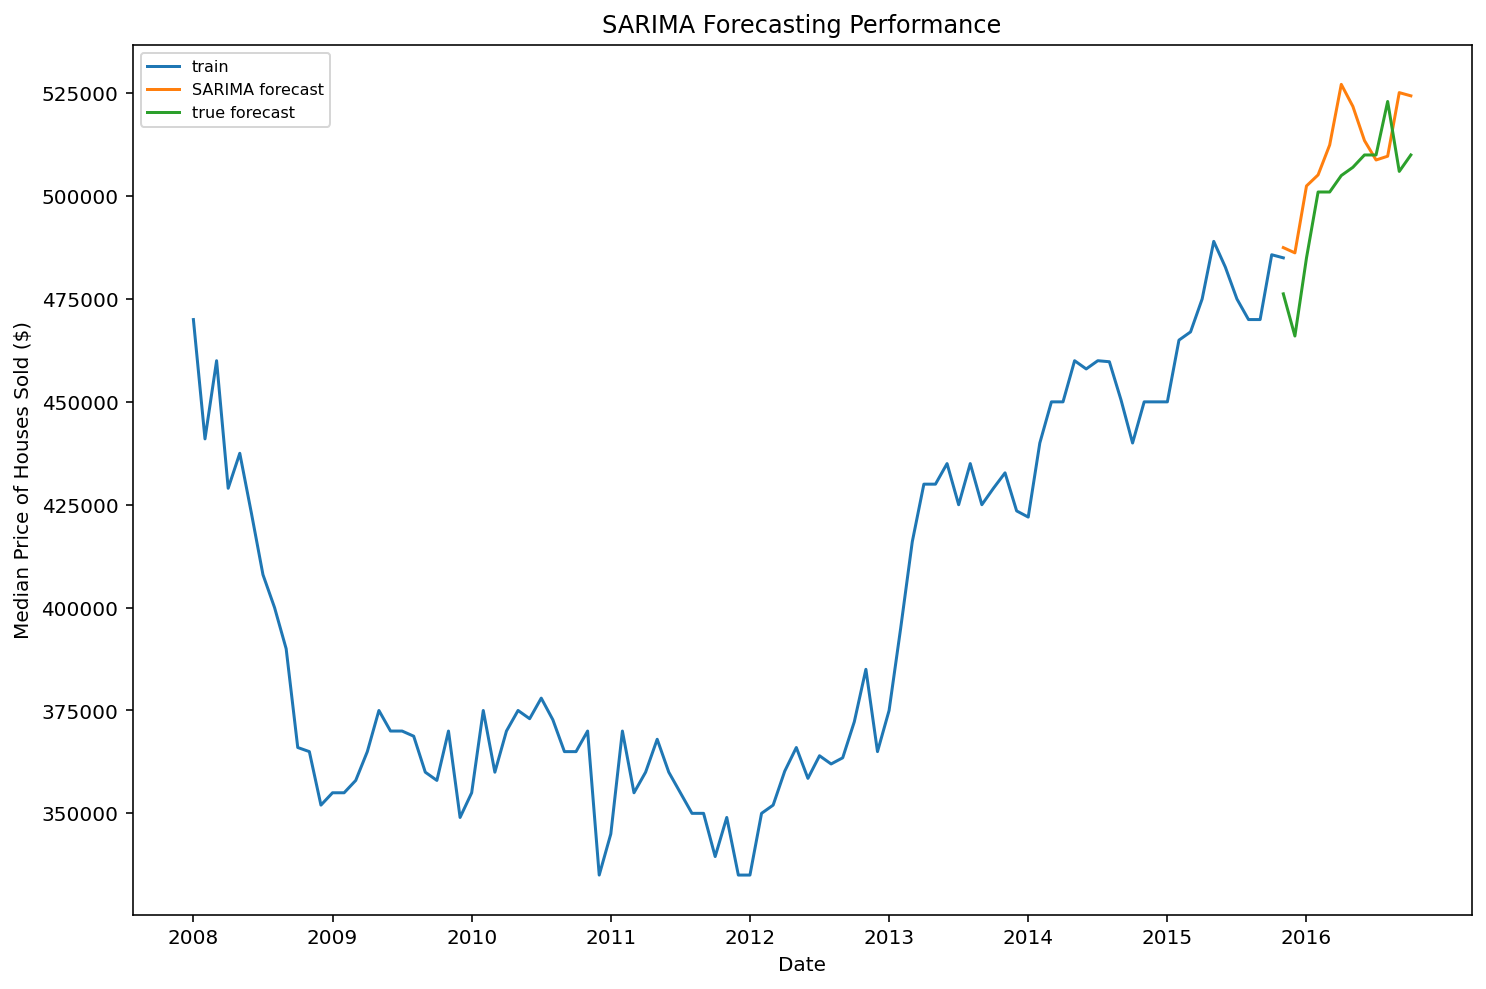

In [ ]:
predh_df = pd.DataFrame(pred1)
predh_df.index += len(final_train) - 1
pred_df = pd.DataFrame(test)
pred_df.index += len(final_train) - 1
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(final_train, label='train')
ax.plot(predh_df, label='SARIMA forecast')
ax.plot(pred_df, label='true forecast')
plt.legend(loc='upper left', fontsize=8)
ax.set_xticks(range(0,107,12))
ax.set_xticklabels(dates)
ax.set_title('SARIMA Forecasting Performance')
ax.set_xlabel('Date')
ax.set_ylabel('Median Price of Houses Sold ($)')
plt.savefig('finalpredictions.jpg', bbox_inches='tight', pad_inches=0.2)